### Reading data

In [2]:
from sclibrary.network_reader import NetworkReader

data_folder = 'data/sample_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)
simplices = G.simplicies(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# coordinates
filename = data_folder + '/coordinates.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")

#### Option 1: CSV

In [5]:
# read csv
data_folder = 'data/london_street'
filename = data_folder + '/LondonEdges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)
simplices = G.simplicies(condition="all", dist_col_name="distance", dist_threshold=1.5)
simplices

[[3],
 [7],
 [9],
 [18],
 [23],
 [25],
 [38],
 [44],
 [45],
 [39],
 [27],
 [24],
 [20],
 [12],
 [8],
 [6],
 [1],
 [16],
 [35],
 [40],
 [46],
 [42],
 [37],
 [28],
 [30],
 [33],
 [34],
 [26],
 [36],
 [48],
 [43],
 [47],
 [57],
 [60],
 [66],
 [4],
 [10],
 [13],
 [11],
 [15],
 [17],
 [5],
 [21],
 [32],
 [31],
 [51],
 [50],
 [49],
 [54],
 [55],
 [52],
 [59],
 [61],
 [58],
 [62],
 [64],
 [65],
 [69],
 [56],
 [2],
 [14],
 [19],
 [22],
 [29],
 [41],
 [53],
 [63],
 [70],
 [68],
 [72],
 [74],
 [75],
 [71],
 [73],
 [67],
 [80],
 [78],
 [77],
 [76],
 [81],
 [82],
 [79],
 [3, 7],
 [3, 6],
 [7, 9],
 [7, 8],
 [9, 18],
 [9, 12],
 [18, 23],
 [18, 20],
 [23, 25],
 [23, 24],
 [25, 38],
 [25, 27],
 [38, 44],
 [38, 39],
 [44, 45],
 [45, 40],
 [45, 46],
 [39, 35],
 [39, 40],
 [27, 24],
 [27, 35],
 [27, 28],
 [24, 20],
 [24, 26],
 [24, 36],
 [24, 21],
 [20, 16],
 [12, 8],
 [12, 16],
 [8, 6],
 [8, 10],
 [6, 1],
 [1, 4],
 [16, 21],
 [35, 37],
 [40, 42],
 [46, 42],
 [46, 48],
 [46, 60],
 [42, 37],
 [37, 28],
 [

In [2]:
# if coordinates exist
filename = data_folder + '/LondonNodes.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=",")
coordinates

{1: (293.0, 2767.0),
 2: (390.0, 8535.0),
 3: (802.0, 1927.0),
 4: (874.0, 3363.0),
 5: (885.0, 6210.0),
 6: (1020.0, 2288.0),
 7: (1036.0, 1720.0),
 8: (1260.0, 2258.0),
 9: (1314.0, 1542.0),
 10: (1410.0, 2722.0),
 11: (1515.0, 4650.0),
 12: (1582.0, 2190.0),
 13: (1902.0, 3911.0),
 14: (2288.0, 8593.0),
 15: (2580.0, 4035.0),
 16: (2790.0, 2002.0),
 17: (2842.0, 7080.0),
 18: (2902.0, 802.0),
 19: (3127.0, 9308.0),
 20: (3330.0, 2025.0),
 21: (3412.0, 3690.0),
 22: (3705.0, 8077.0),
 23: (3802.0, 600.0),
 24: (4185.0, 2160.0),
 25: (4373.0, 555.0),
 26: (4575.0, 2992.0),
 27: (4747.0, 1890.0),
 28: (4792.0, 2175.0),
 29: (4912.0, 9353.0),
 30: (4920.0, 2962.0),
 31: (4965.0, 7485.0),
 32: (4966.0, 6217.0),
 33: (4995.0, 3472.0),
 34: (4996.0, 4718.0),
 35: (5295.0, 1635.0),
 36: (5377.0, 2662.0),
 37: (5452.0, 1905.0),
 38: (5512.0, 420.0),
 39: (5625.0, 1462.0),
 40: (5970.0, 1327.0),
 41: (6067.0, 9248.0),
 42: (6097.0, 1575.0),
 43: (6307.0, 3052.0),
 44: (6382.0, 97.0),
 45: (65

#### Option 2: TNTP

In [10]:
data_folder = 'data/barcelona'
filename = data_folder + "/network.tntp"
delimeter = "\t"
src_col = "Init node "
dest_col = "Term node "

G = NetworkReader.read_tntp(filename=filename, delimeter=delimeter, src_col=src_col, dest_col=dest_col)
simplices = G.simplicies(condition="all")
simplices

[[1.0],
 [290.0],
 [307.0],
 [316.0],
 [2.0],
 [302.0],
 [304.0],
 [3.0],
 [301.0],
 [306.0],
 [4.0],
 [5.0],
 [298.0],
 [299.0],
 [310.0],
 [6.0],
 [424.0],
 [425.0],
 [456.0],
 [7.0],
 [274.0],
 [281.0],
 [283.0],
 [8.0],
 [272.0],
 [474.0],
 [480.0],
 [9.0],
 [277.0],
 [10.0],
 [205.0],
 [206.0],
 [214.0],
 [11.0],
 [207.0],
 [12.0],
 [210.0],
 [217.0],
 [222.0],
 [13.0],
 [208.0],
 [211.0],
 [224.0],
 [14.0],
 [244.0],
 [15.0],
 [228.0],
 [533.0],
 [538.0],
 [16.0],
 [601.0],
 [602.0],
 [17.0],
 [597.0],
 [608.0],
 [621.0],
 [18.0],
 [914.0],
 [937.0],
 [938.0],
 [946.0],
 [19.0],
 [617.0],
 [919.0],
 [931.0],
 [20.0],
 [916.0],
 [21.0],
 [915.0],
 [943.0],
 [22.0],
 [831.0],
 [23.0],
 [823.0],
 [835.0],
 [836.0],
 [839.0],
 [24.0],
 [827.0],
 [838.0],
 [855.0],
 [25.0],
 [821.0],
 [841.0],
 [849.0],
 [26.0],
 [322.0],
 [844.0],
 [851.0],
 [27.0],
 [317.0],
 [333.0],
 [824.0],
 [832.0],
 [28.0],
 [328.0],
 [339.0],
 [825.0],
 [29.0],
 [325.0],
 [331.0],
 [30.0],
 [286.0],
 [340.0],

#### Option 3: Incidence matrices, B1 & B2

In [18]:
# read B1, B2
data_folder = 'data/sample_data'
B1_filename = f'{data_folder}/B1.csv'
B2_filename = f'{data_folder}/B2.csv'
G = NetworkReader.read_incidence_matrix(B1_filename, B2_filename)
simplices = G.simplicies(condition="all")
simplices

[[0],
 [1],
 [2],
 [3],
 [4],
 [0, 1],
 [0, 2],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 3],
 [3, 4],
 [0, 1, 2],
 [1, 2, 3],
 [1, 3, 4]]

### Simplical Complex Analysis

In [3]:
from sclibrary.simplicial_complex import SimplicialComplexNetwork

# create a simplicial complex network
sc = SimplicialComplexNetwork(simplices=simplices)

# analyze the network
sc.adjacency_matrix(rank=1)

/Users/irtaza.hashmi@futurice.com/Desktop/Thesis/sc-graph-library/thesis_venv/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0.]], dtype=float32)

### Eigendecompostion

In [4]:
k = 1
L1 = sc.hodge_laplacian_matrix(rank=k)
L1U = sc.upper_laplacian_matrix(rank=k)
L1L = sc.lower_laplacian_matrix(rank=k)

In [5]:
import numpy as np
from sclibrary.eigendecomposition import (get_harmonic_eigenvectors, 
                                          get_curl_eigenvectors, 
                                          get_gradient_eigenvectors)

u_h, eigenvals_h = get_harmonic_eigenvectors(L1)
u_c, eigenvals_c = get_curl_eigenvectors(L1U)
u_g, eigenvals_g = get_gradient_eigenvectors(L1L)

In [8]:
print("Eigenvalues:", eigenvals_h)
u_h

Eigenvalues: [0.0]


array([[ 0.6172134 ],
       [-0.6172134 ],
       [ 0.38575837],
       [ 0.15430336],
       [ 0.07715168],
       [-0.23145503],
       [-0.07715168]], dtype=float32)

In [9]:
print("Eigenvalues:", eigenvals_c)
u_c

Eigenvalues: [2.0, 4.0]


array([[ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [-5.0000000e-01,  3.5355338e-01],
       [ 4.4930317e-16, -7.0710677e-01],
       [ 5.0000000e-01,  3.5355338e-01],
       [-5.0000000e-01,  3.5355338e-01],
       [-5.0000000e-01, -3.5355338e-01]], dtype=float32)

In [10]:
print("Eigenvalues:", eigenvals_g)
u_g

Eigenvalues: [1.5857865, 3.0, 5.0, 4.4142137]


array([[-5.1877373e-01,  2.8867513e-01, -5.0000000e-01,  1.2879470e-01],
       [-3.0389065e-01,  5.7735026e-01, -6.4459498e-16,  4.3973261e-01],
       [ 2.1488312e-01,  2.8867513e-01,  5.0000000e-01,  3.1093791e-01],
       [-2.1488312e-01,  2.8867513e-01,  5.0000000e-01, -3.1093791e-01],
       [-5.1877373e-01, -2.8867513e-01,  5.0000000e-01,  1.2879470e-01],
       [-4.2976624e-01, -2.8236944e-16,  1.4359947e-16, -6.2187582e-01],
       [-3.0389065e-01, -5.7735026e-01,  9.4069851e-17,  4.3973261e-01]],
      dtype=float32)

### Plotting

Text(0.5, 1.0, 'u_h, λ = 2.0')

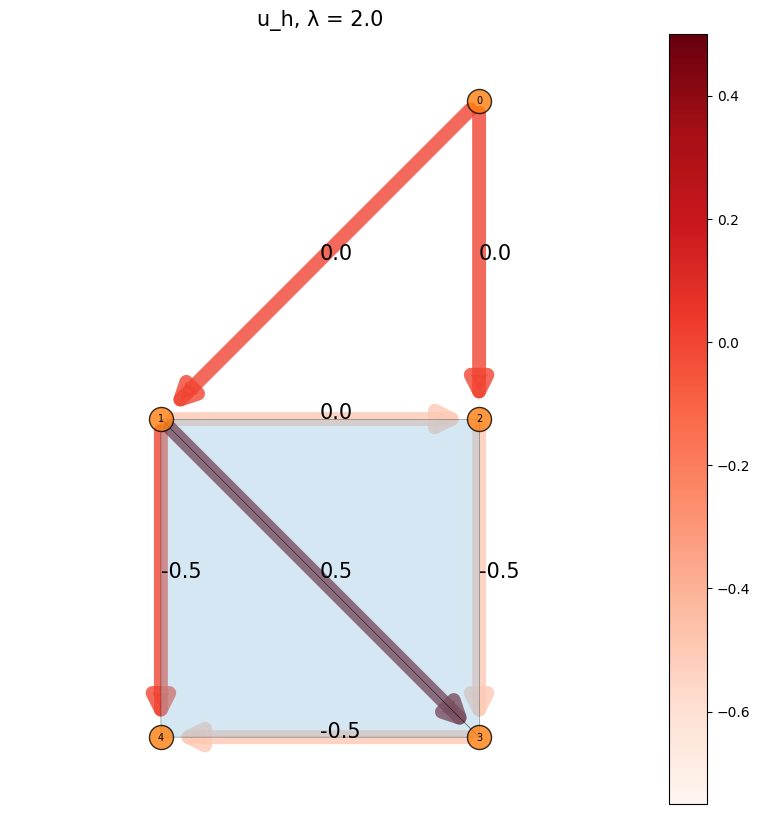

In [6]:
from sclibrary.plot import SCPlot
from matplotlib import pyplot as plt

# get edge labels
edge_labels = {}
for i in range(len(sc.edges)):
    edge_labels[sc.edges[i][0], sc.edges[i][1]] = round(u_c[i][0], 2)
    
# create plot
fig, _ = plt.subplots(figsize=(10, 10))
scplot = SCPlot(sc=sc, pos=coordinates)

# plot nodes and edges
scplot.draw_sc_nodes()
scplot.draw_sc_edges(directed=True, 
                     edge_width=10,
                     arrowsize=30, 
                     edge_color=list(edge_labels.values()),
            
                     )


# plot labels
scplot.draw_node_labels(font_size=7)
scplot.draw_edge_labels(edge_labels=edge_labels, font_size=15)

plt.title("u_h, λ = " + str(eigenvals_c[0]), fontsize=15)

### Filters

In [8]:
L = 10 # order of the filter (order of the matrix polynomial)

lam_l = np.diag() # eigenvalues of L1 (all of them)
Phi_G = np.array([lam_l ** (l - 1) for l in range(1, L + 1)]).T
Phi_G

array([[1.00000e+00, 2.00000e+00, 4.00000e+00, 8.00000e+00, 1.60000e+01,
        3.20000e+01, 6.40000e+01, 1.28000e+02, 2.56000e+02, 5.12000e+02],
       [1.00000e+00, 2.00000e+00, 4.00000e+00, 8.00000e+00, 1.60000e+01,
        3.20000e+01, 6.40000e+01, 1.28000e+02, 2.56000e+02, 5.12000e+02],
       [1.00000e+00, 3.00000e+00, 9.00000e+00, 2.70000e+01, 8.10000e+01,
        2.43000e+02, 7.29000e+02, 2.18700e+03, 6.56100e+03, 1.96830e+04],
       [1.00000e+00, 4.00000e+00, 1.60000e+01, 6.40000e+01, 2.56000e+02,
        1.02400e+03, 4.09600e+03, 1.63840e+04, 6.55360e+04, 2.62144e+05],
       [1.00000e+00, 3.00000e+00, 9.00000e+00, 2.70000e+01, 8.10000e+01,
        2.43000e+02, 7.29000e+02, 2.18700e+03, 6.56100e+03, 1.96830e+04],
       [1.00000e+00, 3.00000e+00, 9.00000e+00, 2.70000e+01, 8.10000e+01,
        2.43000e+02, 7.29000e+02, 2.18700e+03, 6.56100e+03, 1.96830e+04],
       [1.00000e+00, 3.00000e+00, 9.00000e+00, 2.70000e+01, 8.10000e+01,
        2.43000e+02, 7.29000e+02, 2.18700e+03

### Extra

In [24]:
from scipy.linalg import pinv

# Calculate alpha
alpha = pinv(Phi_G) @ np.concatenate([np.array([1]), np.zeros(len(lam_l)-1)])

# Build the filter
H = np.zeros((7, 7))
for l in range(1, L+1):
    H += alpha[l-1] * L1L**(l-1)
    
H

array([[ 4.99989013e-01,  2.52210576e-02, -8.41018630e-03,
        -8.41018630e-03, -8.41018630e-03,  4.01874218e-04,
         4.01874218e-04],
       [ 2.52210576e-02,  4.99989013e-01,  2.52210576e-02,
         4.01874218e-04,  4.01874218e-04, -8.41018630e-03,
         4.01874218e-04],
       [-8.41018630e-03,  2.52210576e-02,  4.99989013e-01,
         2.52210576e-02,  2.52210576e-02, -8.41018630e-03,
         4.01874218e-04],
       [-8.41018630e-03,  4.01874218e-04,  2.52210576e-02,
         4.99989013e-01,  2.52210576e-02,  2.52210576e-02,
        -8.41018630e-03],
       [-8.41018630e-03,  4.01874218e-04,  2.52210576e-02,
         2.52210576e-02,  4.99989013e-01,  4.01874218e-04,
         2.52210576e-02],
       [ 4.01874218e-04, -8.41018630e-03, -8.41018630e-03,
         2.52210576e-02,  4.01874218e-04,  4.99989013e-01,
        -8.41018630e-03],
       [ 4.01874218e-04,  4.01874218e-04,  4.01874218e-04,
        -8.41018630e-03,  2.52210576e-02, -8.41018630e-03,
         4.9998901

In [10]:
# flow geenration
flow = np.random.rand(L1.shape[0], 1)
print("flow", flow)
# analyze frequency components

# spectral decomposition - not flow
flow_h = u_h.T @ flow # coefficients of the flow in the harmonic basis
flow_g = u_g.T @ flow # coefficients of the flow in the gradient basis
flow_c = u_c.T @ flow # coefficients of the flow in the curl basis
print("flow_h", flow_h)
print("flow_g", flow_g)
print("flow_c", flow_c)

flow [[0.11450893]
 [0.31080368]
 [0.21274476]
 [0.15173042]
 [0.41463632]
 [0.97363966]
 [0.04415734]]
flow_h [[-0.21244589]]
flow_g [[-0.78770249]
 [ 0.17252394]
 [ 0.33230129]
 [-0.36227225]]
flow_c [[-0.40795272]
 [ 0.44314471]]
